<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mask-R-CNN-Demo" data-toc-modified-id="Mask-R-CNN-Demo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mask R-CNN Demo</a></span><ul class="toc-item"><li><span><a href="#Configurations" data-toc-modified-id="Configurations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Configurations</a></span></li><li><span><a href="#Create-Model-and-Load-Trained-Weights" data-toc-modified-id="Create-Model-and-Load-Trained-Weights-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create Model and Load Trained Weights</a></span></li><li><span><a href="#Class-Names" data-toc-modified-id="Class-Names-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Class Names</a></span></li><li><span><a href="#Run-Object-Detection" data-toc-modified-id="Run-Object-Detection-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Run Object Detection</a></span></li></ul></li></ul></div>

# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import gpu_picker

In [2]:
gpu_picker.gpu_memory_map()

{0: 11718, 1: 0, 2: 0, 3: 0}

In [3]:
gpu_picker.list_available_gpus()

[0, 1, 2, 3]

In [4]:
gpu_picker.pick_gpu_lowest_memory()

1

In [5]:
gpu_picker.setup_one_gpu()

Picking GPU 1


In [6]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn.utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/cordun/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/cordun/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [7]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()





Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Create Model and Load Trained Weights

In [8]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [9]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

/home/cordun/anaconda2/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/cordun/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


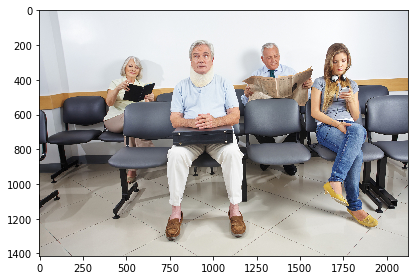

In [10]:
filename = os.path.join(IMAGE_DIR, 'waiting_room.jpg')
image = skimage.io.imread(filename)
skimage.io.imshow(image)

Processing 1 images
image                    shape: (1414, 2121, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2121.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


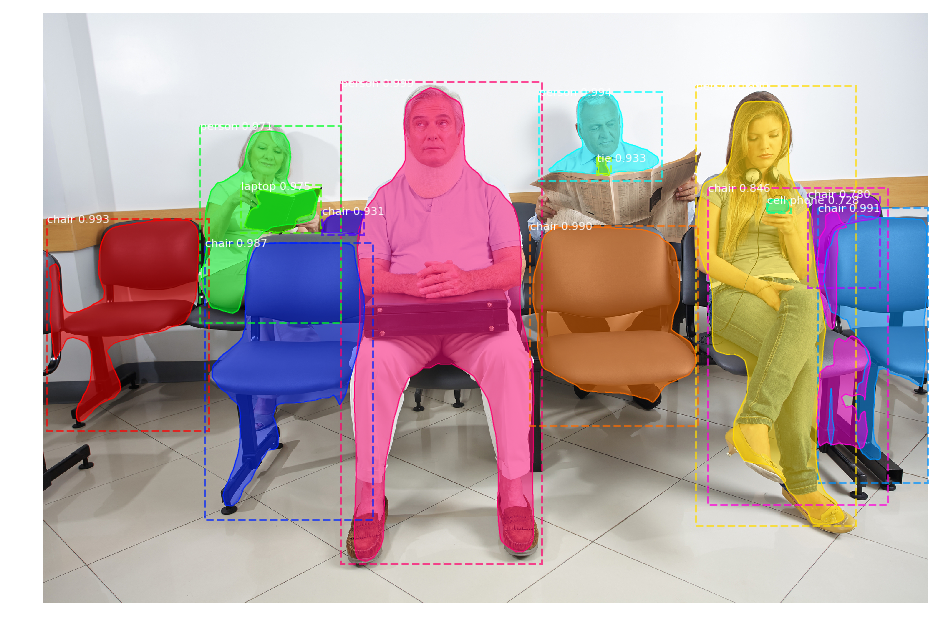

In [11]:
# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

filename = os.path.join(IMAGE_DIR, 'waiting_room.jpg')
image = skimage.io.imread(filename)



# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [12]:
print(r['class_ids'])
print(r['scores'])

[ 1  1 57 57  1 57 57 64  1 28 57 57 57 68]
[0.9993217  0.9941788  0.9932579  0.99123037 0.9898552  0.9898011
 0.98702407 0.9747468  0.9705486  0.9333828  0.93080795 0.8461135
 0.78030884 0.7278788 ]


In [13]:
class_names.index('person')

1

In [14]:
type(class_names)

list

In [15]:
type(r['class_ids'])

numpy.ndarray

In [16]:
def classitems():
    classitems = []
    for item in class_names:
        classitems.append(class_names.index(item))
    return classitems

items_frame = classitems()

In [17]:
items_frame

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80]

In [18]:
import pandas as pd

class_mapper = pd.DataFrame(
    {'class_name': class_names,
     'class_id': items_frame
    })

class_mapper

class_id     class_name
0          0             BG
1          1         person
2          2        bicycle
3          3            car
4          4     motorcycle
5          5       airplane
6          6            bus
7          7          train
8          8          truck
9          9           boat
10        10  traffic light
11        11   fire hydrant
12        12      stop sign
13        13  parking meter
14        14          bench
15        15           bird
16        16            cat
17        17            dog
18        18          horse
19        19          sheep
20        20            cow
21        21       elephant
22        22           bear
23        23          zebra
24        24        giraffe
25        25       backpack
26        26       umbrella
27        27        handbag
28        28            tie
29        29       suitcase
..       ...            ...
51        51       broccoli
52        52         carrot
53        53        hot dog
54        54          pizza
55        55          donut
56        56           cake
57        57          chair
58        58          couch
59        59   potted plant
60        60            bed
61        61   dining table
62        62         toilet
63        63             tv
64        64         laptop
65        65          mouse
66        66         remote
67        67       keyboard
68        68     cell phone
69        69      microwave
70        70           oven
71        71        toaster
72        72           sink
73        73   refrigerator
74        74           book
75        75          clock
76        76           vase
77        77       scissors
78        78     teddy bear
79        79     hair drier
80        80     toothbrush

[81 rows x 2 columns]

In [19]:
print(class_mapper.loc[class_mapper['class_id'].isin(r['class_ids'])])

    class_id  class_name
1          1      person
28        28         tie
57        57       chair
64        64      laptop
68        68  cell phone


In [20]:
import collections
from collections import Counter

Counter(r['class_ids'])

Counter({1: 4, 57: 7, 64: 1, 28: 1, 68: 1})

In [21]:
type(Counter(r['class_ids']))

collections.Counter

In [22]:
counterlist = list(collections.Counter(r['class_ids']).items())

In [23]:
counterlist

[(1, 4), (57, 7), (64, 1), (28, 1), (68, 1)]

In [24]:
class_counterlist = pd.DataFrame(counterlist)
class_counterlist.columns = ['class_id', 'freq']
class_counterlist

class_id  freq
0         1     4
1        57     7
2        64     1
3        28     1
4        68     1

In [25]:
fin_for_this_image = pd.merge(class_mapper, class_counterlist, on='class_id')

In [26]:
fin_for_this_image

class_id  class_name  freq
0         1      person     4
1        28         tie     1
2        57       chair     7
3        64      laptop     1
4        68  cell phone     1

Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


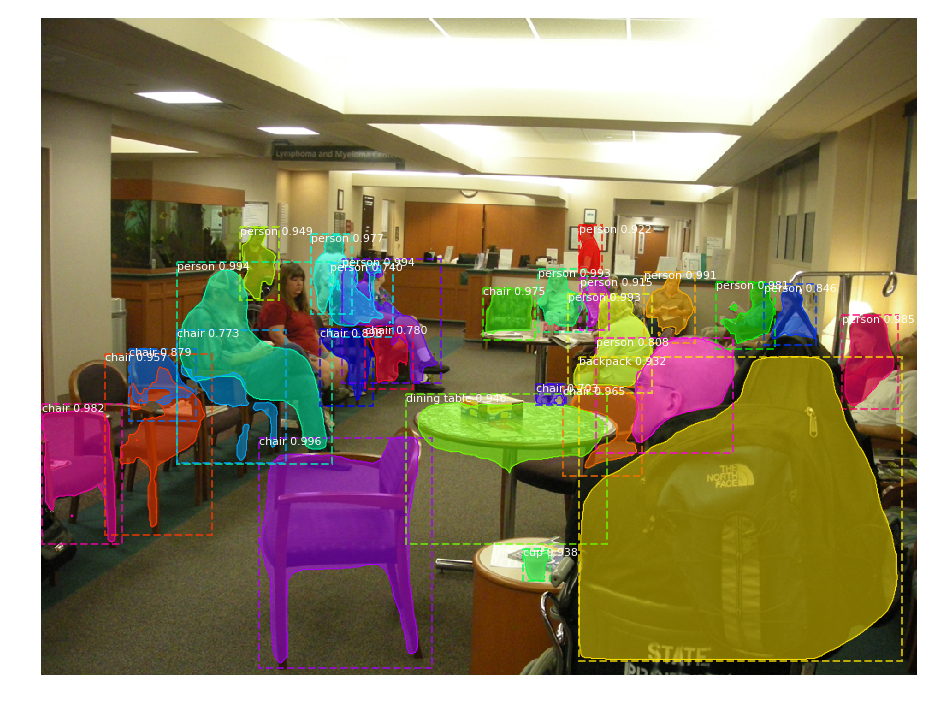

In [27]:
filename = os.path.join(IMAGE_DIR, 'waiting_room2.jpg')
image = skimage.io.imread(filename)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (455, 810, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


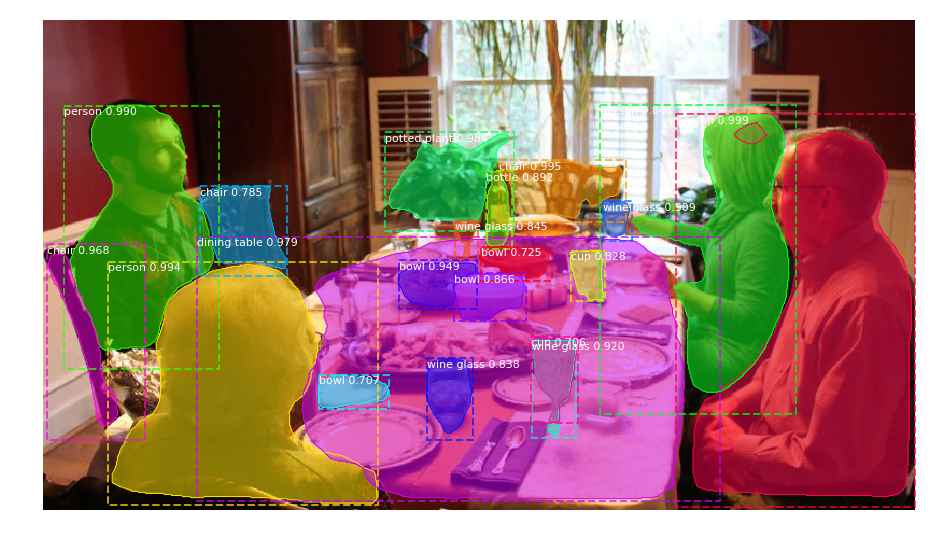

In [28]:
filename = os.path.join(IMAGE_DIR, 'dinner_table.jpg')
image = skimage.io.imread(filename)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (916, 687, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


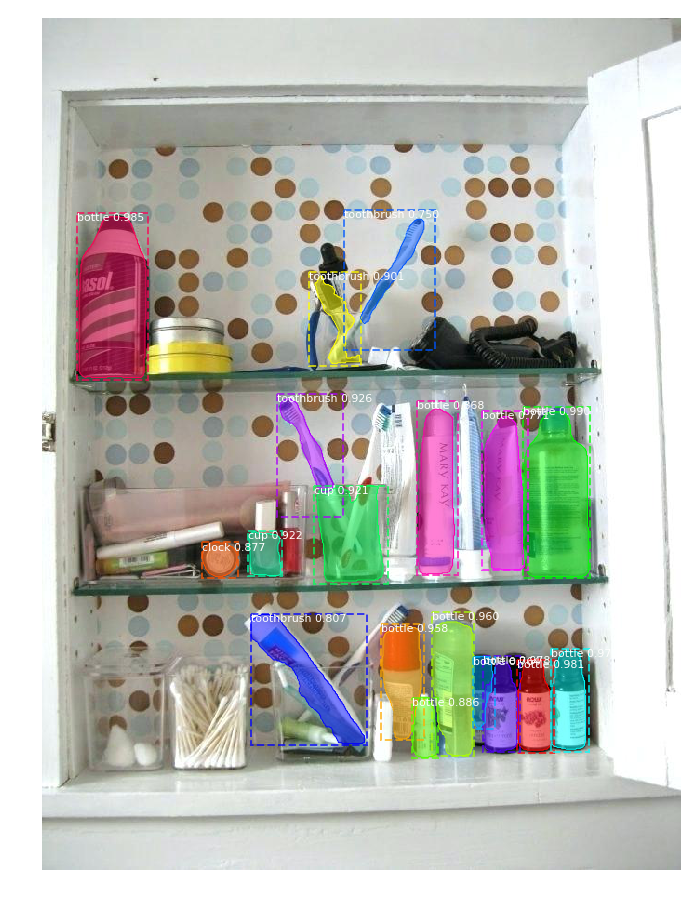

In [29]:
filename = os.path.join(IMAGE_DIR, 'medicine_cabinet.jpg')
image = skimage.io.imread(filename)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (1600, 1200, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


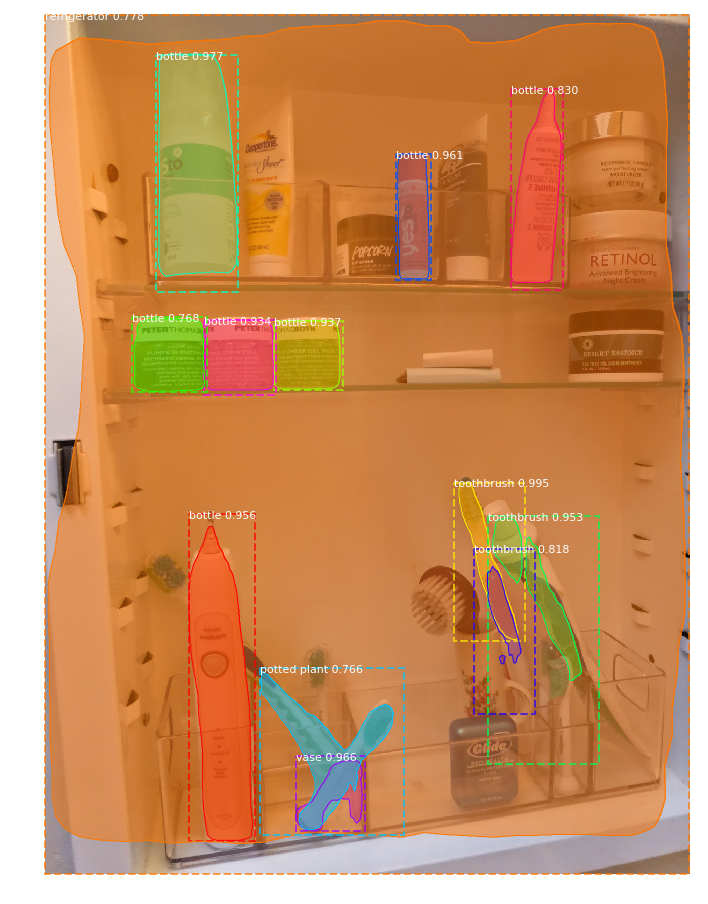

In [31]:
filename = os.path.join(IMAGE_DIR, 'medicine_cabinet2.jpg')
image = skimage.io.imread(filename)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])